## Model Development

Melakukan import library yang dibutuhkan

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import adjustText
import tensorflow_hub as hub
import seaborn as sns

Melakukan import dataset

In [5]:
df_data = pd.read_csv('../Data/data_2/clean_review_160k.csv')
df_data

,text,rating,label
0,near airport good shuttle service stay night w...,2.0,negative
1,get low rank reason positive thing say hotel s...,1.0,negative
2,budget hotel pretend resort really motel level...,2.0,negative
3,dish extra buck stay elsewhere place look acce...,1.0,negative
4,l budget good low cost brand hotel near downto...,2.0,negative
...,...,...,...
141737,fantastic mid range hotel u find well stay hot...,5.0,positive
141738,fantastic service staff encounter property mak...,4.0,positive
141739,great find stay previously stay theatre distri...,4.0,positive
141740,convenient location airport stay start road tr...,4.0,positive


In [11]:
df_data[df_data['text'].str.isspace()]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

### TF-IDF Method

TFIDF pada studi kasus ini digunakan untuk menampilkan kata-kata yang paling unique pada masing-masing sentimen.

In [6]:
negative_reviews = df_data[df_data['label'] == 'negative']['text']
positive_reviews = df_data[df_data['label'] == 'positive']['text']
neutral_reviews = df_data[df_data['label'] == 'neutral']['text']


all_reviews = df_data['text']

vectorizer = TfidfVectorizer()
tfidf_all = vectorizer.fit_transform(all_reviews)

tfidf_negative = vectorizer.transform(negative_reviews)
tfidf_positive = vectorizer.transform(positive_reviews)
tfidf_neutral = vectorizer.transform(neutral_reviews)

top_words_negative = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_negative.toarray(), axis=0))} 
top_words_positive = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_positive.toarray(), axis=0))}
top_words_neutral = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_neutral.toarray(), axis=0))}

wordcloud_negative = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_negative)
wordcloud_positive = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_positive)
wordcloud_neutral = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_neutral)

ValueError: np.nan is an invalid document, expected byte or unicode string.

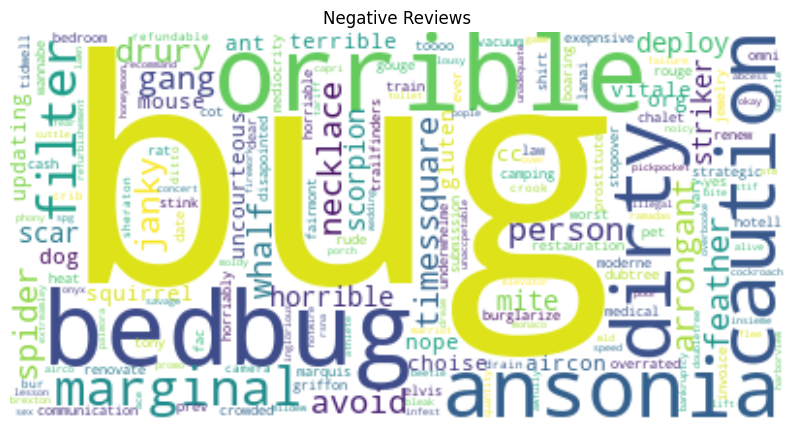

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")
plt.show()


Dari wordcloud yang dihasilkan, kita bisa melihat kata-kata yang unique pada negatif sentiment seperti "bug", "bedbug", "terrible", dll.

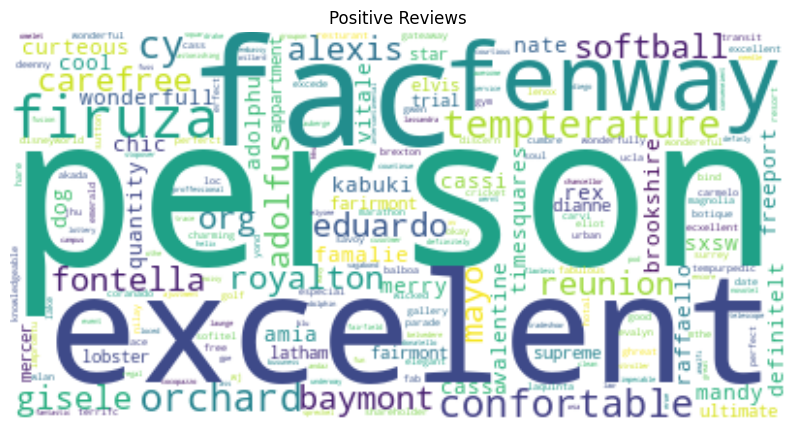

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")
plt.show()


Dari wordcloud yang dihasilkan, kita bisa melihat kata-kata yang unique pada positif sentiment seperti "cool", "great", "excellent", dll.

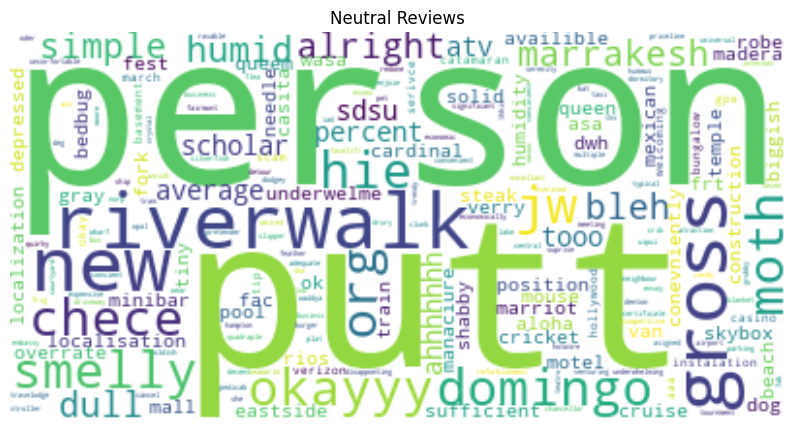

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")
plt.show()

Dari wordcloud yang dihasilkan, kita bisa melihat kata-kata yang unique pada netral sentiment seperti "comfortabel", dll.

### Neural Network Method

Langkah pertama adalah yaitu melakukan encoding pada label sentiment.

In [ ]:
encoding_5label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}


In [ ]:
df_data['label'] = df_data['label'].map(encoding_5label)
df_data

,text,rating,label
0,near airport with good shuttle service stay he...,2.0,2
1,get a low ranking for a reason I have few posi...,1.0,2
2,budget hotel pretend to be a resort the hanale...,2.0,2
3,dish out a few extra buck and stay elsewhere t...,1.0,2
4,l a on a budget the good low cost for a brand ...,2.0,2
...,...,...,...
62866,could not ask for a well hotel experience grea...,5.0,0
62867,a little gem we be not stay in GPE DATE DATE f...,5.0,0
62868,love my night in the ORG great location clean ...,5.0,0
62869,a great experience just return from a night st...,5.0,0


Setelah itu akan dilakukan split data menjadi train, test, dan validation dengan rasio 80:10:10. Rasio ini ditentukan berdasarkan ukuran dataset yang cukup besar.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape

((50296,), (6287,), (50296,), (6287,), (6288,), (6288,))

Karena akan menggunakan pretrained model dari tensorflow, untuk itu harus dilakukan konversi data menjadi format tensor

In [ ]:
x_train_tensor = tf.convert_to_tensor(x_train)
y_train_tensor = tf.convert_to_tensor(y_train)
x_test_tensor = tf.convert_to_tensor(x_test)
y_test_tensor = tf.convert_to_tensor(y_test)
x_val_tensor = tf.convert_to_tensor(x_val)
y_val_tensor = tf.convert_to_tensor(y_val)

Selanjutnya akan dilakukan trainning model dengan memanfaatkan pretrained model dari tensorflow. Hal ini dilakukan karena dataset yang digunakan cukup besar dan memerlukan waktu yang sangat lama untuk trainning model dari awal, sehingga memanfaatkan pretrained model akan mempercepat proses trainning model.

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 48,194,059
Trainable params: 48,194,059
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train_tensor, y_train_tensor, epochs=10, batch_size=256, validation_data=(x_test_tensor, y_test_tensor))

Epoch 1/10
197/197 [==============================] - 122s 617ms/step - loss: 0.8108 - accuracy: 0.6547 - val_loss: 0.5937 - val_accuracy: 0.7663
Epoch 2/10
197/197 [==============================] - 124s 632ms/step - loss: 0.5817 - accuracy: 0.7744 - val_loss: 0.5451 - val_accuracy: 0.7815
Epoch 3/10
197/197 [==============================] - 123s 626ms/step - loss: 0.5258 - accuracy: 0.7987 - val_loss: 0.5313 - val_accuracy: 0.7845
Epoch 4/10
197/197 [==============================] - 121s 614ms/step - loss: 0.4898 - accuracy: 0.8146 - val_loss: 0.5312 - val_accuracy: 0.7845
Epoch 5/10
197/197 [==============================] - 124s 630ms/step - loss: 0.4595 - accuracy: 0.8282 - val_loss: 0.5313 - val_accuracy: 0.7834
Epoch 6/10
197/197 [==============================] - 127s 646ms/step - loss: 0.4350 - accuracy: 0.8404 - val_loss: 0.5369 - val_accuracy: 0.7776
Epoch 7/10
197/197 [==============================] - 120s 610ms/step - loss: 0.4101 - accuracy: 0.8523 - val_loss: 0.5513 -

Setelah dilakukan trainning model, akan dilakukan evaluasi model dengan menggunakan data validation.

In [ ]:
val_loss, val_accuracy = model.evaluate(x_val_tensor, y_val_tensor)

197/197 [==============================] - 12s 62ms/step - loss: 0.5985 - accuracy: 0.7692


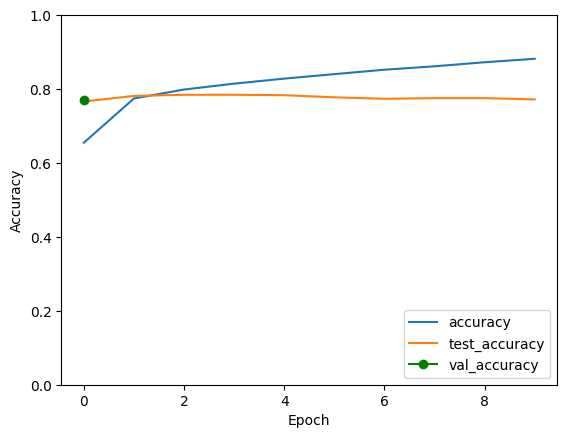

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.plot(val_accuracy, label='val_accuracy',marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Dari plot yang dihasilkan, kita bisa melihat bahwa model yang dibuat sudah cukup baik dalam memprediksi sentiment dari review yang diberikan, tidak terjadi overfitting dan underfitting.

Tahap selanjutnya yaitu melakukan evaluasi metric dalam studi kasus ini menggunakan confusion matrix

In [ ]:
predictions = model.predict(x_val_tensor)
predictions = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_val, predictions)

197/197 [==============================] - 12s 58ms/step


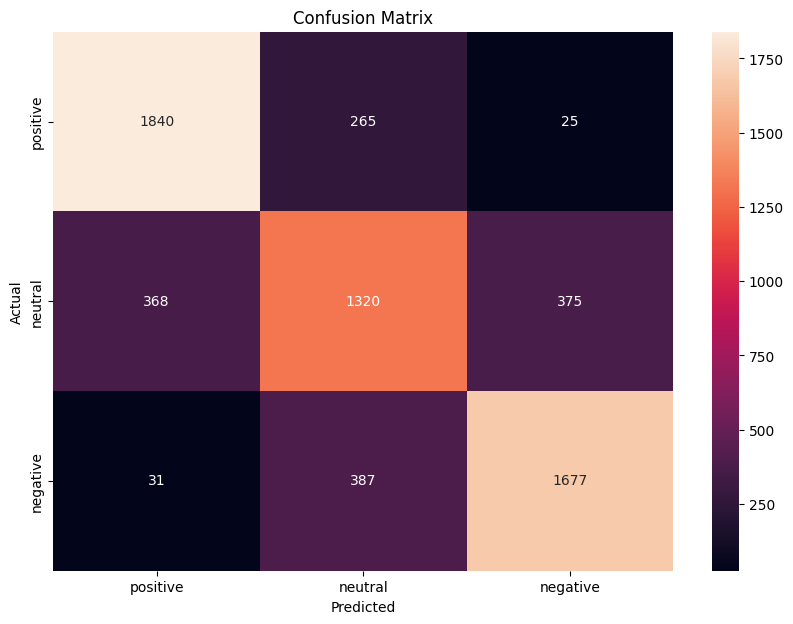

In [ ]:
df_confusion_matrix = pd.DataFrame(conf_matrix, index = ['positive', 'neutral', 'negative'], columns = ['positive', 'neutral', 'negative'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_confusion_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Dari confusion matrix yang dihasilkan, pada label neutral terlihat beberapa data yang salah diprediksi sebagai label negatif dan positif. Hal ini bisa terjadi karena kata-kata yang digunakan pada review netral bisa saja mirip dengan kata-kata yang digunakan pada review negatif atau positif, begitu juga sebaliknya. Hal ini menunjukkan terdapat data yang beririsan antara label negatif, positif, dan netral, sehingga harus dilakukan preprocessing lebih lanjut untuk menangani hal ini.

In [ ]:
embeddings = model.layers[0].get_weights()[0]
pca = PCA(n_components=10, random_state=42).fit_transform(embeddings)
embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=35).fit_transform(pca)

word_index = hub_layer.get_vocabulary()

magnitudes = np.linalg.norm(embeddings, axis=1)
top_indices = magnitudes.argsort()[-200:]
top_words = {word: index for word, index in word_index.items() if index in top_indices}

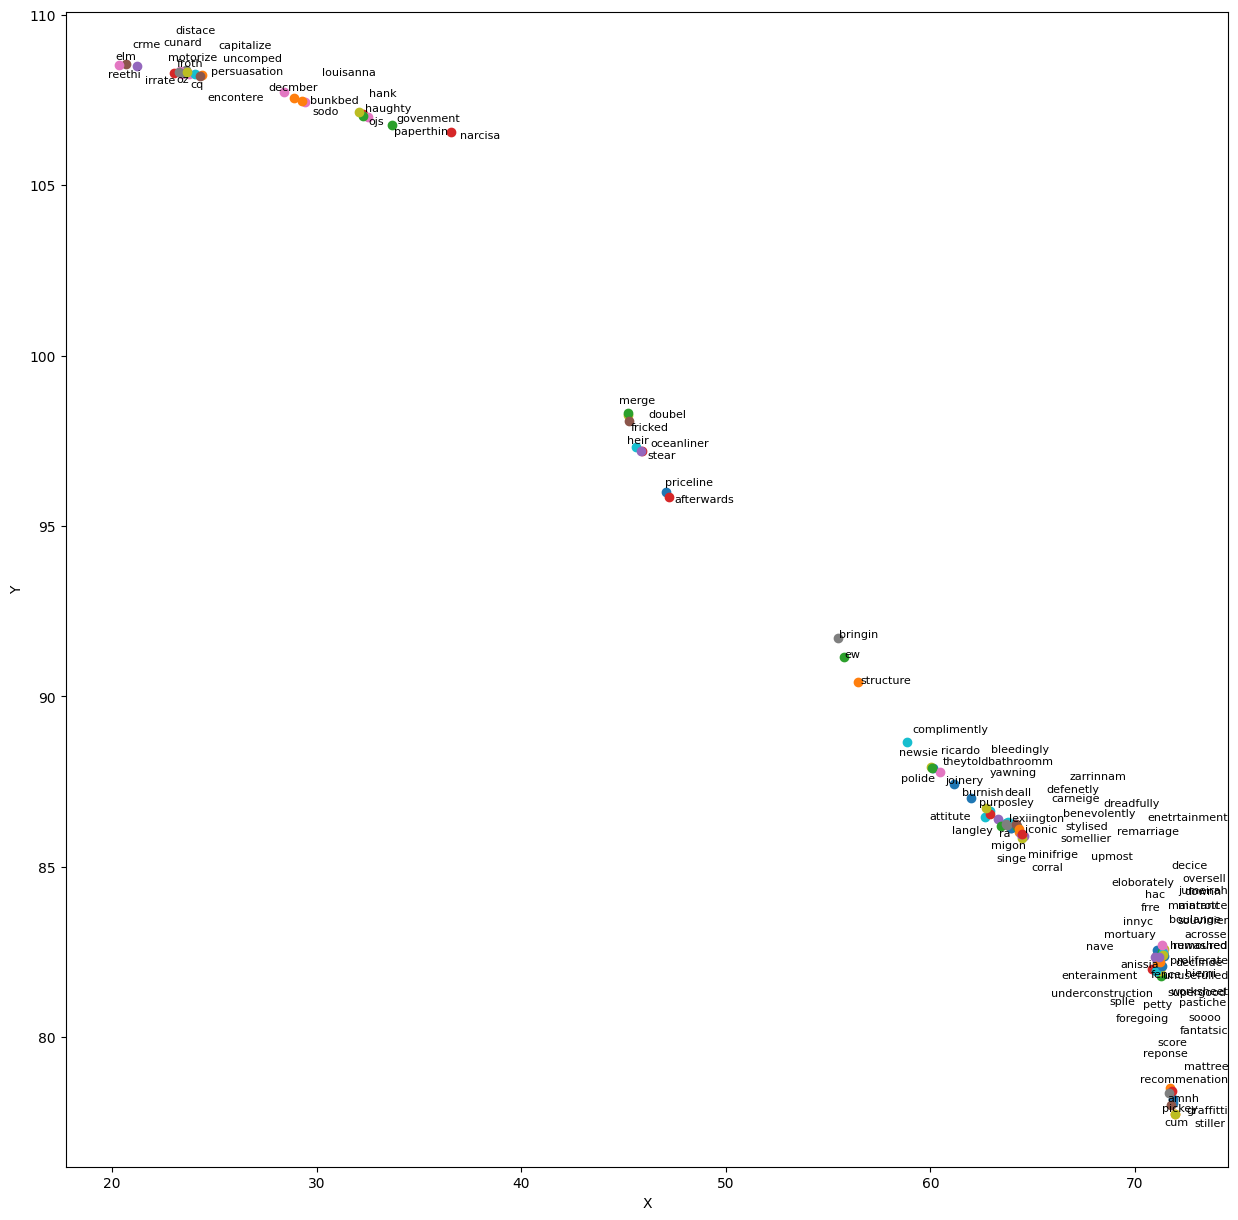

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

for word, index in top_words.items():
    x, y = embeddings_2d[index]
    ax.scatter(x, y)
    ax.text(x, y, word, fontsize=8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
adjustText.adjust_text(ax.texts,iterations=100)

plt.show()

In [ ]:
model.save('model_2.h5')